In [2]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

In [8]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'{i}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after three rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


In [7]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text()
        headline = x.a.get_text()
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

In [9]:
# NLTK VADER for sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
 
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

vader = SentimentIntensityAnalyzer()
# Instantiate the sentiment intensity analyzer with the existing lexicon

#vader = SentimentIntensityrAnalyzer()

# Update the lexicon
vader.lexicon.update(new_words)

In [10]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date)


C:\Users\Admin\AppData\Local\Temp\ipykernel_18940\2723012903.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  scored_news['date'] = pd.to_datetime(scored_news.date)


<Axes: xlabel='date'>

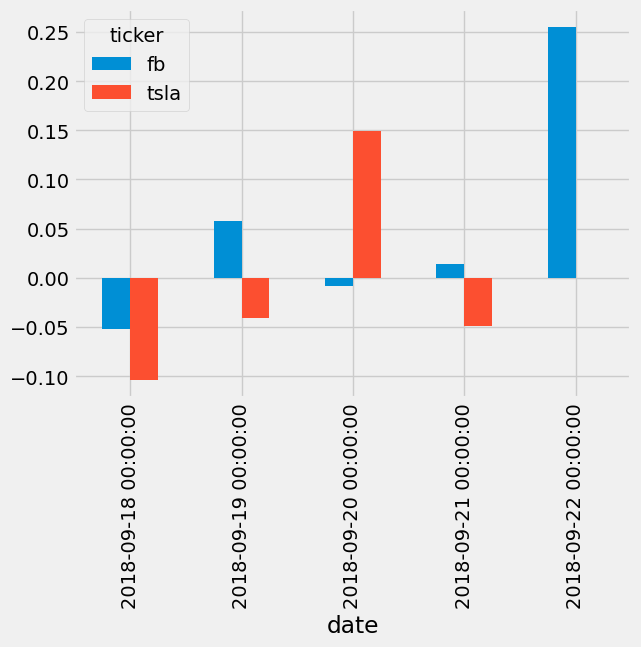

In [11]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean(numeric_only=True)
# Unstack the column ticker
mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
# Plot a bar chart with pandas
mean_c.plot.bar()

In [15]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean.headline.count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 200 headlines, now we have 188'

In [16]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.loc['fb']
# Select the 3rd of January of 2019
single_day = single_day.loc['2018-09-21']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time'])
# Set the index to time and 
single_day['time'] = single_day.time.dt.time
# Sort it
single_day.set_index('time', inplace=True)
single_day=single_day.sort_index(ascending=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18940\4016195415.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  single_day['time'] = pd.to_datetime(single_day['time'])


Text(0, 0.5, 'scores')

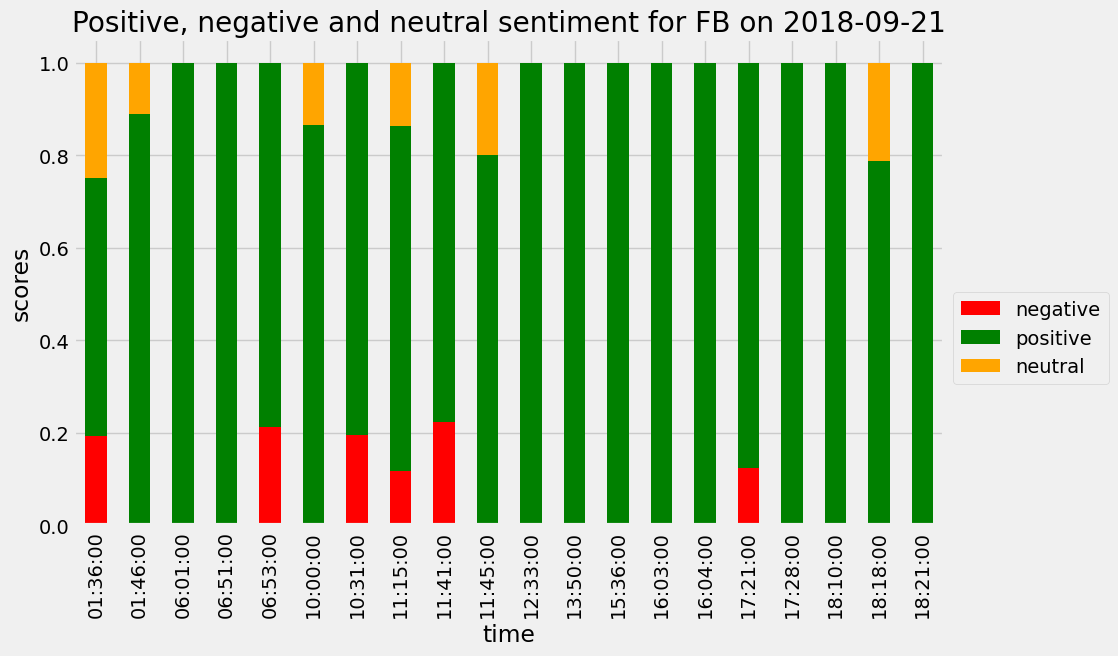

In [18]:
TITLE = "Positive, negative and neutral sentiment for FB on 2018-09-21"
COLORS = ["red", "green", "orange"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores")

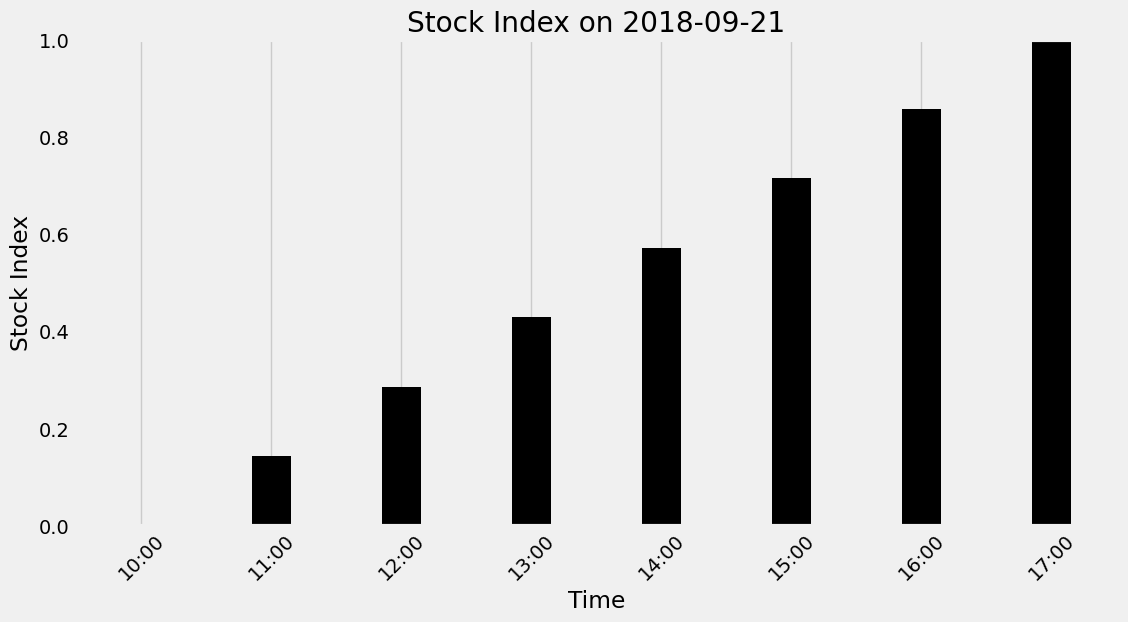

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data for the stock index ranging from 0 to 1
stock_index = np.linspace(0, 1, 8)  # 8 points for 1-hour intervals

# Define the corresponding time points as hours of the day
time_hours = [f"{hour:02}:00" for hour in range(10, 18)]  

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(time_hours, stock_index, width=0.3, color='black')
plt.title('Stock Index on 2018-09-21')
plt.xlabel('Time')
plt.ylabel('Stock Index')
plt.grid(axis='y')
plt.ylim(0, 1)  # Set the y-axis limits to 0 and 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
